In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import gzip
import os
import requests
from anndata import AnnData
import scanpy as sc
from scipy import stats
import copy
import pickle
seed=314159
device='cuda'
import sys
sys.path.insert(0, '/home/hechu/GPerturb')
from GPerturb import *

In [2]:
adata = sc.read('./SciPlex2_new.h5ad')

torch.manual_seed(3141592)
# load data:
my_conditioner = pd.read_csv("./SciPlex2_perturbation.csv", index_col=0)
my_conditioner = my_conditioner.drop('Vehicle', axis=1)  # TODO: or retaining it
cond_name = list(my_conditioner.columns)
my_conditioner = torch.tensor(my_conditioner.to_numpy() * 1.0, dtype=torch.float)
my_conditioner = torch.pow(my_conditioner, 0.2)  # a power transformation of dosages

my_observation = pd.read_csv("./SciPlex2.csv", index_col=0)
print(my_observation.shape)
my_observation = torch.tensor(my_observation.to_numpy() * 1.0, dtype=torch.float)

gene_name = list(pd.read_csv('./SciPlex2_gene_name.csv').to_numpy()[:, 0])

my_cell_info = pd.read_csv("./SciPlex2_cell_info.csv", index_col=0)
my_cell_info.n_genes = my_cell_info.n_genes/my_cell_info.n_counts
my_cell_info.n_counts = np.log(my_cell_info.n_counts)
cell_info_names = list(my_cell_info.columns)
my_cell_info = torch.tensor(my_cell_info.to_numpy() * 1.0, dtype=torch.float)

(20643, 5000)


In [3]:
# design the training process:
start = time.time()
output_dim = my_observation.shape[1]
sample_size = my_observation.shape[0]
hidden_node = 700  # or 1000
hidden_layer = 4
conditioner_dim = my_conditioner.shape[1]
cell_info_dim = my_cell_info.shape[1]

lr_parametric = 1e-3  
nu_1, nu_2, nu_3, nu_4, nu_5, nu_6 = torch.tensor([1., 1e-2, 1., 1e-2, 3., 1e-2]).to(device)
tau = torch.tensor(1.).to(device)

parametric_model = GPerturb_Gaussian(conditioner_dim=conditioner_dim, output_dim=output_dim, base_dim=cell_info_dim,
                               data_size=sample_size, hidden_node=hidden_node, hidden_layer_1=hidden_layer,
                               hidden_layer_2=hidden_layer, tau=tau)
parametric_model.test_id = testing_idx = list(np.random.choice(a=range(my_observation.shape[0]), size=my_observation.shape[0] // 8, replace=False))
parametric_model = parametric_model.to(device)

# train from scratch
parametric_model.GPerturb_train(epoch=250, observation=my_observation, cell_info=my_cell_info, perturbation=my_conditioner, 
                                 nu_1=nu_1, nu_2=nu_2, nu_3=nu_3, nu_4=nu_4, nu_5=nu_5, nu_6=nu_6, lr=lr_parametric, device=device)

EPOCH=0, test_error=-20081.38671875
EPOCH=0, training_error=-15075.9443359375
EPOCH=10, test_error=-25798.68359375
EPOCH=10, training_error=-26267.328125
EPOCH=20, test_error=-26303.0078125
EPOCH=20, training_error=-27069.681640625
EPOCH=30, test_error=-26826.662109375
EPOCH=30, training_error=-27740.380859375
EPOCH=40, test_error=-26831.69921875
EPOCH=40, training_error=-28311.98046875
EPOCH=50, test_error=-27014.353515625
EPOCH=50, training_error=-28828.2109375
EPOCH=60, test_error=-27304.58984375
EPOCH=60, training_error=-29276.861328125
EPOCH=70, test_error=-27180.1484375
EPOCH=70, training_error=-29660.47265625
EPOCH=80, test_error=-27099.619140625
EPOCH=80, training_error=-29985.927734375
EPOCH=90, test_error=-27258.763671875
EPOCH=90, training_error=-30257.962890625
EPOCH=100, test_error=-27267.505859375
EPOCH=100, training_error=-30502.8984375
EPOCH=110, test_error=-27580.6796875
EPOCH=110, training_error=-30711.6171875
EPOCH=120, test_error=-27651.24609375
EPOCH=120, training_

In [4]:
parametric_model=parametric_model.to('cpu')

In [5]:
def logexpp1(x):
    ans = 1.0*x
    ans[x < 12.] = torch.log(torch.exp(x[x < 12.]) + 1.)+1e-4
    return ans

In [6]:
# compute from model
predicted_mu_mean, predicted_mu_var, predicted_gamma_mean, predicted_gamma_var, \
    logit_p, logit_p_log_var, predicted_base_mean = parametric_model(my_conditioner[parametric_model.test_id], my_cell_info[parametric_model.test_id])
estimated_base_mean = predicted_base_mean.detach().cpu().numpy()
estimated_perturbed_mean = (F.sigmoid(logit_p) * predicted_mu_mean).detach().cpu().numpy()
estimated_total_mean = (estimated_perturbed_mean + estimated_base_mean)
estimated_perturbed_var = logexpp1(parametric_model.base_log_var + (F.sigmoid(logit_p) * predicted_gamma_mean)).detach().cpu().numpy()


avg_unique_pert = np.zeros((len(adata.obs.drug_dose_name.unique()), output_dim))
avg_obs = np.zeros((len(adata.obs.drug_dose_name.unique()), output_dim))
unique_pert = np.array(adata.obs.drug_dose_name.unique())
baseline_id = 0
for i, name in enumerate(list(adata.obs.drug_dose_name.unique())):
    if name == 'Vehicle_1.0':
        baseline_id = i
        print(i)
    avg_unique_pert[i] = estimated_total_mean[np.array(adata.obs.drug_dose_name[parametric_model.test_id] == name)].mean(axis=0)
    avg_obs[i] = my_observation[np.array(adata.obs.drug_dose_name == name)].mean(axis=0).numpy()
avg_obs = np.delete(avg_obs, baseline_id, 0)
avg_unique_pert = np.delete(avg_unique_pert, baseline_id, 0)

4


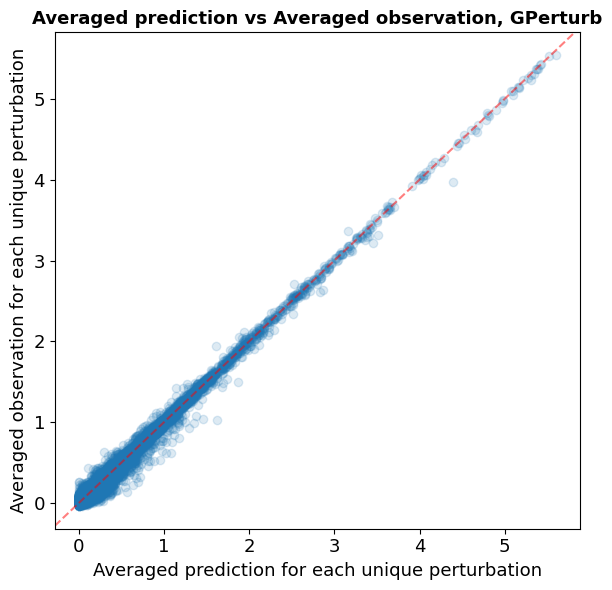

In [11]:
fig, ax = plt.subplots(1, 1)  

ax.scatter(avg_obs.ravel(), avg_unique_pert.ravel(), alpha=0.15)
ax.axline((1, 1), slope=1, c='r', alpha=0.5, linestyle='--')
ax.set_xlabel('Averaged prediction for each unique perturbation', fontsize=13)
ax.set_ylabel('Averaged observation for each unique perturbation', fontsize=13)
ax.set_title('Averaged prediction vs Averaged observation, GPerturb', fontsize=13, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=13)
fig.set_size_inches(6, 6)
fig.tight_layout()

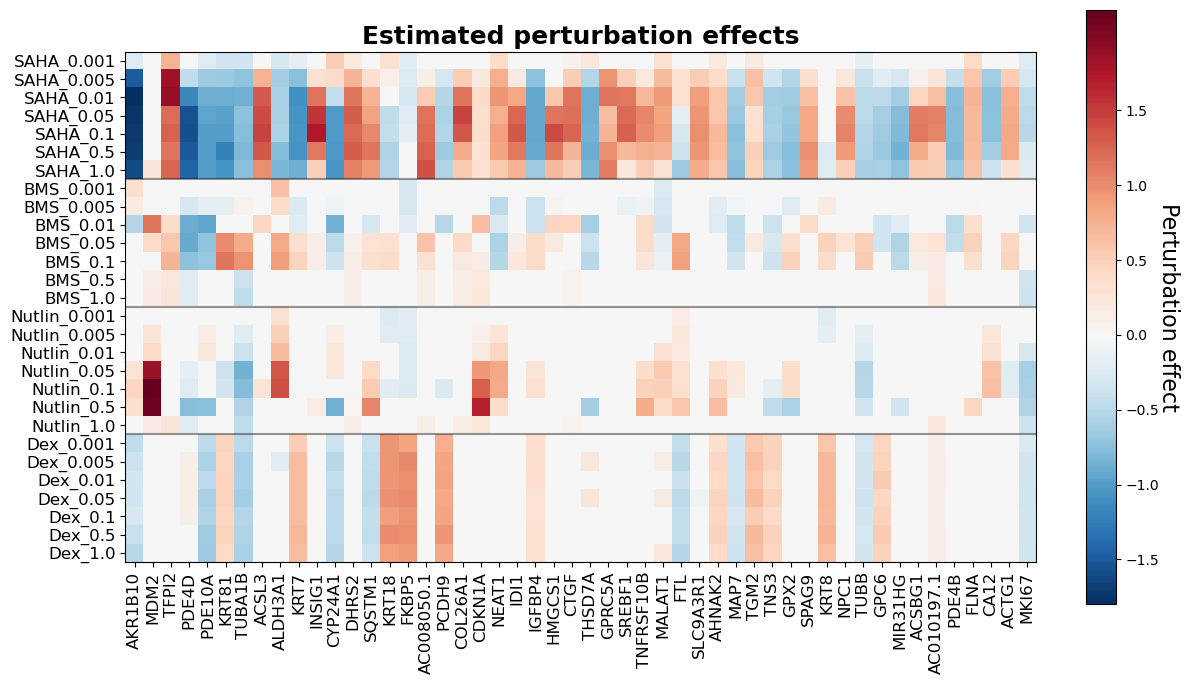

In [ ]:
# compute from model
p = 0.95
top=50
unique_conditions = torch.unique(my_conditioner, dim=0)
perturb_level, _, _, _, logit_p, _, _ = parametric_model(unique_conditions, None)
estimated_inclusion_prob = F.sigmoid(logit_p).detach().cpu().numpy()
estimated_inclusion = estimated_inclusion_prob > p
my_gene_name = np.array(gene_name)[estimated_inclusion.sum(axis=0) > 0]
estimated_inclusion_prob = estimated_inclusion_prob[:, estimated_inclusion.mean(axis=0) > 0]
estimated_pert = perturb_level.detach().cpu().numpy() * estimated_inclusion
estimated_pert = estimated_pert[:, estimated_inclusion.mean(axis=0) > 0]
top_id = np.argsort((estimated_pert**2).sum(axis=0))[::-1][:top]
estimated_pert = estimated_pert[:, top_id]
my_gene_name = my_gene_name[top_id]

unique_conditions = unique_conditions.numpy()
my_yticks = ['' for _ in range(unique_conditions.shape[0])]
for i in range(unique_conditions.shape[0]):
    if np.all(unique_conditions[i] == 0):
        my_yticks[i] = 'Vehicle_1.0'
    else:
        my_yticks[i] = np.array(cond_name)[unique_conditions[i] != 0.][0] + '_' + str(np.round((unique_conditions[i][unique_conditions[i] != 0][0])**5,3))

fig, ax1 = plt.subplots(1,1)

import matplotlib.colors as colors
negatives = estimated_pert.min()
positives = estimated_pert.max()

num_neg_colors = int(256 / (positives - negatives) * (-negatives))
num_pos_colors = 256 - num_neg_colors
cmap_BuRd = plt.cm.RdBu_r
colors_2neg_4pos = [cmap_BuRd(0.5*c/num_neg_colors) for c in range(num_neg_colors)] +\
[cmap_BuRd(1-0.5*c/num_pos_colors) for c in range(num_pos_colors)][::-1]
cmap_2neg_4pos = colors.LinearSegmentedColormap.from_list('cmap_2neg_4pos', colors_2neg_4pos, N=256)

im = ax1.imshow(estimated_pert[1:], cmap=cmap_2neg_4pos)
for i in [6.5, 13.5, 20.5]:
    ax1.axline((i, i), slope=0, alpha=0.4, c='k')
ax1.set_xticks(np.arange(len(my_gene_name)), my_gene_name, rotation=90, fontsize=12)
ax1.set_yticks(np.arange(len(my_yticks)-1), my_yticks[1:], fontsize=12)
ax1.set_title('Estimated perturbation effects', fontsize=18, fontweight='bold')
ticks = np.append(np.arange(-2., 0., .5), np.arange(0, 2, 0.5))
cbar = fig.colorbar(im, ax=ax1, ticks=ticks, fraction=0.03)
cbar.ax.set_ylabel('Perturbation effect', rotation=270, labelpad=15, fontsize=16)
fig.set_size_inches(12, 8)
fig.tight_layout()

In [20]:
degs = ['ACSL3', 'PDE4D', 'CDKN1A','MDM2', 'KRT18', 'PDE10A']
# compute from model
perturb_level, _, _, _, logit_p, _, base_mean = parametric_model(my_conditioner, my_cell_info)
GPerturb_base = base_mean.detach().cpu().numpy().mean(0)
GPerturb_avg_pred = []
for i in range(4):
    print(i)
    uc = torch.zeros((30, 4))
    uc[:, i] = torch.pow(10**torch.linspace(-3, 0, 30), 0.2)
    perturb_level, pert_level_log_var, _, _, logit_p, _, _ = parametric_model(uc, None)
    pert_upper = perturb_level + 2*torch.exp(0.5 * pert_level_log_var)
    pert_lower = perturb_level - 2*torch.exp(0.5 * pert_level_log_var)
    pert_est = (perturb_level * F.sigmoid(logit_p)).detach().cpu().numpy() + GPerturb_base[np.newaxis, :]
    pert_est_upper = (pert_upper * F.sigmoid(logit_p)).detach().cpu().numpy() + GPerturb_base[np.newaxis, :]
    pert_est_lower = (pert_lower * F.sigmoid(logit_p)).detach().cpu().numpy() + GPerturb_base[np.newaxis, :]
    pert_est = pert_est[:, [gene_name.index(i) for i in degs]]
    pert_est_upper = pert_est_upper[:, [gene_name.index(i) for i in degs]]
    pert_est_lower = pert_est_lower[:, [gene_name.index(i) for i in degs]]

    for k, j in enumerate(10**np.linspace(-3, 0, 30)):
        GPerturb_avg_pred.append(pd.DataFrame({'pert': [np.array(cond_name)[uc[0] != 0.][0]]*len(degs), 'dose': j,
                                            'gene': degs, 'BSAPR': pert_est[k], 'BSAPR_upper':pert_est_upper[k],
                                            'BSAPR_lower':pert_est_lower[k]}))
GPerturb_avg_pred = pd.concat(GPerturb_avg_pred)

0
1
2
3


In [21]:
degs = ['ACSL3', 'PDE4D', 'CDKN1A', 'MDM2', 'KRT18', 'PDE10A']
pert_types = ['Dex', 'Nutlin', 'BMS', 'SAHA']
doses = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
gene_indices = [gene_name.index(gene) for gene in degs]
obs_avg_data = []

unique_pert_no_baseline = np.delete(unique_pert, baseline_id, 0)

for i, name in enumerate(unique_pert_no_baseline):
    parts = name.split('_')
    if len(parts) >= 2:
        pert = parts[0]
        dose_str = parts[1]
        if pert in pert_types:
            try:
                dose = float(dose_str)
                avg_values = avg_obs[i]  
                for j, gene in enumerate(degs):
                    gene_idx = gene_indices[j]
                    obs_value = avg_values[gene_idx]
                    
                    obs_avg_data.append({
                        'gene': gene,
                        'pert': pert,
                        'dose': dose,
                        'obs': obs_value
                    })
            except ValueError:
                print(f"error: {dose_str}")
obs_avg = pd.DataFrame(obs_avg_data)

obs_avg = obs_avg.sort_values(['gene', 'pert', 'dose']).reset_index(drop=True)

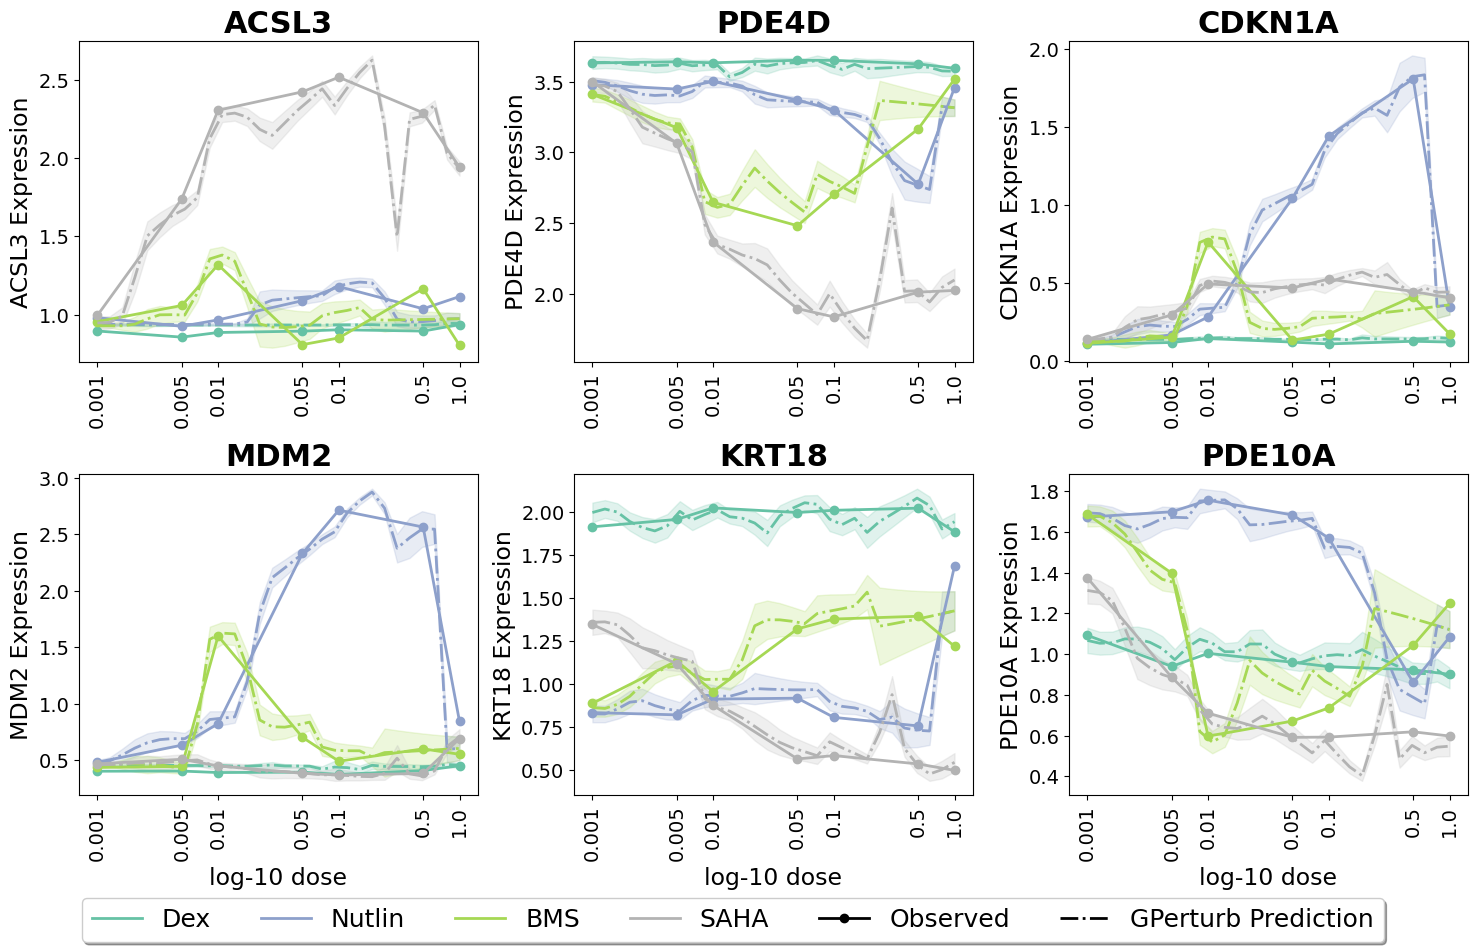

In [34]:
#viridis = cm.get_cmap('viridis')
#new_colors = [viridis(0.2), viridis(0.4), viridis(0.6), viridis(0.8)]  
#cmap = cm.get_cmap('Set3')
#new_colors = [cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.8)]
#cmap = cm.get_cmap('tab10')
#new_colors = [cmap(0), cmap(1), cmap(2), cmap(3)]
cmap = cm.get_cmap('Set2')
new_colors = [cmap(0.0), cmap(0.3), cmap(0.6), cmap(0.9)] 

f, a = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  

for i in range(6):
    row = i // 3  
    col = i % 3   
    my_data_obs = obs_avg[obs_avg.gene == degs[i]]
    my_data_GPerturb = GPerturb_avg_pred[GPerturb_avg_pred.gene == degs[i]]
    lty = ['-', '-.']  
    for idx, j in enumerate(['Dex', 'Nutlin', 'BMS', 'SAHA']):
        a[row, col].plot(np.log10([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]), 
                            np.array(my_data_obs[my_data_obs.pert == j].sort_values(by='dose').obs), 
                            linestyle=lty[0], marker='o', c=new_colors[idx], label=j, linewidth=2)
        
        a[row, col].plot(np.linspace(-3, 0, 30),
                            np.array(my_data_GPerturb[my_data_GPerturb.pert == j].sort_values(by='dose').BSAPR), 
                            linestyle=lty[1], c=new_colors[idx], linewidth=2)
        
        a[row, col].fill_between(np.linspace(-3, 0, 30),
                                    np.array(my_data_GPerturb[my_data_GPerturb.pert == j].sort_values(by='dose').BSAPR_lower),
                                    np.array(my_data_GPerturb[my_data_GPerturb.pert == j].sort_values(by='dose').BSAPR_upper), 
                                    alpha=0.2, color=new_colors[idx])
    
    a[row, col].set_title(degs[i], fontdict={'fontsize': 22, 'fontweight': 'bold'})
    a[row, col].set_xticks(ticks=np.log10([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]), 
                               labels=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0], rotation=90, fontsize=14)
    if row == 1:  
        a[row, col].set_xlabel('log-10 dose', fontdict={'fontsize': 17})
    else:
        a[row, col].set_xlabel('')
    
    a[row, col].set_ylabel(degs[i] + ' Expression', fontdict={'fontsize': 17})
    a[row, col].tick_params(axis='y', labelsize=14)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=new_colors[0], lw=2, label='Dex'),
    Line2D([0], [0], color=new_colors[1], lw=2, label='Nutlin'),
    Line2D([0], [0], color=new_colors[2], lw=2, label='BMS'),
    Line2D([0], [0], color=new_colors[3], lw=2, label='SAHA'),
    Line2D([0], [0], color='k', lw=2, linestyle='-', marker='o', label='Observed'),
    Line2D([0], [0], color='k', lw=2, linestyle='-.', label='GPerturb Prediction')
]

f.legend(handles=legend_elements, loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0), 
         prop={'size': 18}, frameon=True, fancybox=True, shadow=True)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()

In [30]:
print(gene_name)

['SCYL3', 'C1orf112', 'GCLC', 'STPG1', 'RAD52', 'MYH16', 'BAD', 'KLHL13', 'ICA1', 'TFPI', 'MTMR7', 'PLXND1', 'CD38', 'PDK4', 'CALCR', 'THSD7A', 'FAM214B', 'PON1', 'GCFC2', 'ABCB4', 'ZNF195', 'FBXL3', 'ITGA2B', 'CRLF1', 'ABCC8', 'MAP3K9', 'KDM7A', 'ETV1', 'CCL26', 'FARP2', 'USH1C', 'DNAH9', 'GAS7', 'ST7L', 'PAX6', 'CACNA2D2', 'NOX1', 'CYTH3', 'SPAG9', 'AASS', 'PLEKHG6', 'CRY1', 'ST3GAL1', 'MMP25', 'TENM1', 'MASP2', 'RANBP9', 'ETV7', 'FUZ', 'IDS', 'ZNF200', 'CD4', 'BTK', 'SCMH1', 'HIVEP2', 'RNF216', 'PLAUR', 'ANLN', 'WIZ', 'GABRA3', 'BRCA1', 'NR1H4', 'MAP4K5', 'SLC7A14', 'CLDN11', 'CLK1', 'GPRC5A', 'ZC3H3', 'MDH1', 'YAF2', 'IGF1', 'WWTR1', 'CYP24A1', 'SYT13', 'HGF', 'ZFP64', 'RUNX3', 'SERPINB1', 'NRXN3', 'OSBPL5', 'CPS1', 'SLC45A4', 'ZDHHC6', 'GRAMD1B', 'BIRC3', 'DEPDC1', 'TYMP', 'AGPAT4', 'MIPEP', 'IFNGR1', 'POU2F2', 'MUSK', 'IKZF2', 'ZCCHC8', 'LRRC7', 'GAB2', 'SLC4A7', 'ASTE1', 'RNF19A', 'SH3YL1', 'DEPDC1B', 'DAPK2', 'ADSS', 'RFC1', 'NSUN2', 'TLL1', 'VCAN', 'DNAH5', 'BEST2', 'PHLPP2', 

In [35]:
degs = ['SCYL3', 'C1orf112', 'GCLC', 'STPG1', 'RAD52', 'MYH16']
# compute from model
perturb_level, _, _, _, logit_p, _, base_mean = parametric_model(my_conditioner, my_cell_info)
GPerturb_base = base_mean.detach().cpu().numpy().mean(0)
GPerturb_avg_pred = []
for i in range(4):
    print(i)
    uc = torch.zeros((30, 4))
    uc[:, i] = torch.pow(10**torch.linspace(-3, 0, 30), 0.2)
    perturb_level, pert_level_log_var, _, _, logit_p, _, _ = parametric_model(uc, None)
    pert_upper = perturb_level + 2*torch.exp(0.5 * pert_level_log_var)
    pert_lower = perturb_level - 2*torch.exp(0.5 * pert_level_log_var)
    pert_est = (perturb_level * F.sigmoid(logit_p)).detach().cpu().numpy() + GPerturb_base[np.newaxis, :]
    pert_est_upper = (pert_upper * F.sigmoid(logit_p)).detach().cpu().numpy() + GPerturb_base[np.newaxis, :]
    pert_est_lower = (pert_lower * F.sigmoid(logit_p)).detach().cpu().numpy() + GPerturb_base[np.newaxis, :]
    pert_est = pert_est[:, [gene_name.index(i) for i in degs]]
    pert_est_upper = pert_est_upper[:, [gene_name.index(i) for i in degs]]
    pert_est_lower = pert_est_lower[:, [gene_name.index(i) for i in degs]]

    for k, j in enumerate(10**np.linspace(-3, 0, 30)):
        GPerturb_avg_pred.append(pd.DataFrame({'pert': [np.array(cond_name)[uc[0] != 0.][0]]*len(degs), 'dose': j,
                                            'gene': degs, 'BSAPR': pert_est[k], 'BSAPR_upper':pert_est_upper[k],
                                            'BSAPR_lower':pert_est_lower[k]}))
GPerturb_avg_pred = pd.concat(GPerturb_avg_pred)

0
1
2
3


In [36]:
degs = ['SCYL3', 'C1orf112', 'GCLC', 'STPG1', 'RAD52', 'MYH16']
pert_types = ['Dex', 'Nutlin', 'BMS', 'SAHA']
doses = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
gene_indices = [gene_name.index(gene) for gene in degs]
obs_avg_data = []

unique_pert_no_baseline = np.delete(unique_pert, baseline_id, 0)

for i, name in enumerate(unique_pert_no_baseline):
    parts = name.split('_')
    if len(parts) >= 2:
        pert = parts[0]
        dose_str = parts[1]
        if pert in pert_types:
            try:
                dose = float(dose_str)
                avg_values = avg_obs[i]  
                for j, gene in enumerate(degs):
                    gene_idx = gene_indices[j]
                    obs_value = avg_values[gene_idx]
                    
                    obs_avg_data.append({
                        'gene': gene,
                        'pert': pert,
                        'dose': dose,
                        'obs': obs_value
                    })
            except ValueError:
                print(f"error: {dose_str}")
obs_avg = pd.DataFrame(obs_avg_data)

obs_avg = obs_avg.sort_values(['gene', 'pert', 'dose']).reset_index(drop=True)

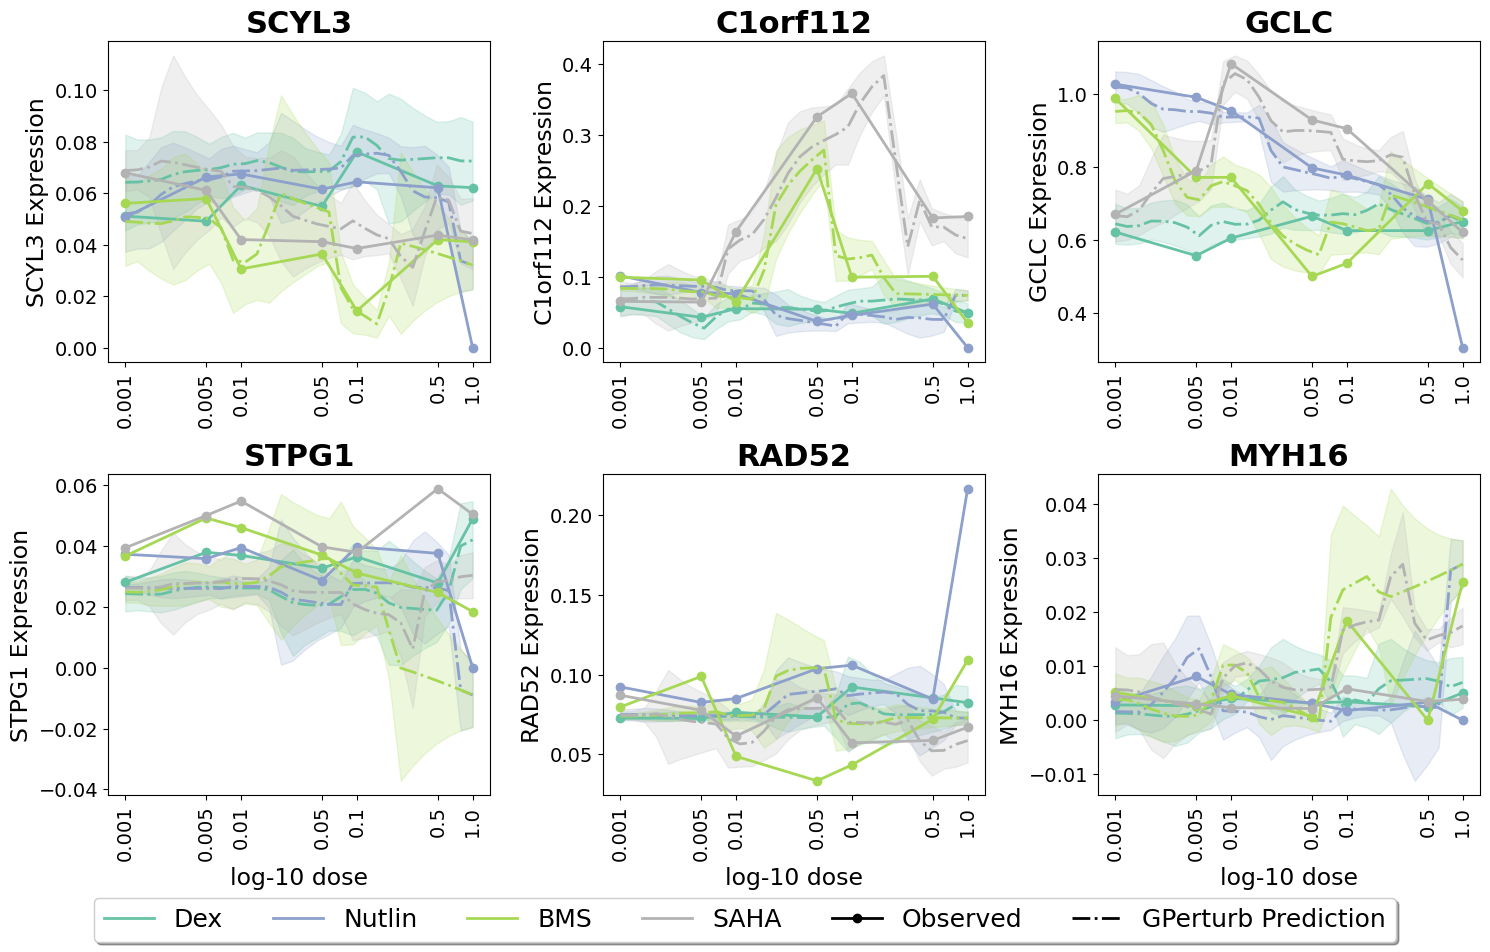

In [37]:
#viridis = cm.get_cmap('viridis')
#new_colors = [viridis(0.2), viridis(0.4), viridis(0.6), viridis(0.8)]  
#cmap = cm.get_cmap('Set3')
#new_colors = [cmap(0.2), cmap(0.4), cmap(0.6), cmap(0.8)]
#cmap = cm.get_cmap('tab10')
#new_colors = [cmap(0), cmap(1), cmap(2), cmap(3)]
cmap = cm.get_cmap('Set2')
new_colors = [cmap(0.0), cmap(0.3), cmap(0.6), cmap(0.9)] 

f, a = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  

for i in range(6):
    row = i // 3  
    col = i % 3   
    my_data_obs = obs_avg[obs_avg.gene == degs[i]]
    my_data_GPerturb = GPerturb_avg_pred[GPerturb_avg_pred.gene == degs[i]]
    lty = ['-', '-.']  
    for idx, j in enumerate(['Dex', 'Nutlin', 'BMS', 'SAHA']):
        a[row, col].plot(np.log10([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]), 
                            np.array(my_data_obs[my_data_obs.pert == j].sort_values(by='dose').obs), 
                            linestyle=lty[0], marker='o', c=new_colors[idx], label=j, linewidth=2)
        
        a[row, col].plot(np.linspace(-3, 0, 30),
                            np.array(my_data_GPerturb[my_data_GPerturb.pert == j].sort_values(by='dose').BSAPR), 
                            linestyle=lty[1], c=new_colors[idx], linewidth=2)
        
        a[row, col].fill_between(np.linspace(-3, 0, 30),
                                    np.array(my_data_GPerturb[my_data_GPerturb.pert == j].sort_values(by='dose').BSAPR_lower),
                                    np.array(my_data_GPerturb[my_data_GPerturb.pert == j].sort_values(by='dose').BSAPR_upper), 
                                    alpha=0.2, color=new_colors[idx])
    
    a[row, col].set_title(degs[i], fontdict={'fontsize': 22, 'fontweight': 'bold'})
    a[row, col].set_xticks(ticks=np.log10([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.]), 
                               labels=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0], rotation=90, fontsize=14)
    if row == 1:  
        a[row, col].set_xlabel('log-10 dose', fontdict={'fontsize': 17})
    else:
        a[row, col].set_xlabel('')
    
    a[row, col].set_ylabel(degs[i] + ' Expression', fontdict={'fontsize': 17})
    a[row, col].tick_params(axis='y', labelsize=14)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=new_colors[0], lw=2, label='Dex'),
    Line2D([0], [0], color=new_colors[1], lw=2, label='Nutlin'),
    Line2D([0], [0], color=new_colors[2], lw=2, label='BMS'),
    Line2D([0], [0], color=new_colors[3], lw=2, label='SAHA'),
    Line2D([0], [0], color='k', lw=2, linestyle='-', marker='o', label='Observed'),
    Line2D([0], [0], color='k', lw=2, linestyle='-.', label='GPerturb Prediction')
]

f.legend(handles=legend_elements, loc='lower center', ncol=6, bbox_to_anchor=(0.5, 0), 
         prop={'size': 18}, frameon=True, fancybox=True, shadow=True)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()